# Analysis of Byonic data for Glyco Peptidome

In [1]:
library(tidyverse)
library(cowplot)
library(scales)
library(readxl)
library(magrittr)
library(formatR)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──



✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1



── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()




Attaching package: ‘scales’




The following object is masked from ‘package:purrr’:

    discard




The following object is masked from ‘package:readr’:

    col_factor





Attaching package: ‘magrittr’




The following object is masked from ‘package:purrr’:

    set_names




The following object is masked from ‘package:tidyr’:

    extract




In [2]:
proteins <- ("P05814" = "MKVLILACLVALALARETIESLSSSEESITEYKQKVEKVKHEDQQQGEDEHQDKIYPSFQPQPLIYPFVEPIPYGFLPQNILPLAQPAVVLPVPQPEIMEVPKAKDTVYTKGRVMPVLKSPTIPFFDPQIPKLTDLENLHLPLPLLQPLMQQVPQPIPQTLALPPQPLWSVPQPKVLPIPQQVVPYPQRAVPVQALLLNQELLLNPTHQIYPVTQPLAPVHNPISV")

## Functions

In [3]:
# General mass table
glycanmasses <- c(
          "Hex"    = 162.0528,
          "dHex"   = 146.0579,
          "HexNAc" = 203.079377,
          "Fuc"    = 146.057913,
          "NeuAc"  = 291.095421,
          "NeuGc"  = 307.090336,
          "KDN"    = 250.068872 )

modmasses <- c(
          "Cam"    = 57.02146,
          "P"      = 79.96633089,
          "H2O"    = 18.01056,
          "O"      = 15.995 )

abbreviations <- c(
          "HexNAc" = "N",
          "dHex"   = "F",
          "Fuc"    = "F",
          "NeuAc"  = "S",
          "Hex"    = "H" )

In [4]:
calculate_mass_lookup <- function(glycan_composition) {

      glycanmasses_tbl <- tibble(name = names(glycanmasses), mass = glycanmasses)

      parts <- str_split(glycan_composition, pattern = "\\)")
      parts <- lapply(parts, str_split, pattern = "\\(")

      results <- sapply(
        parts,
        FUN = function(entry) {
          outcome <- sum(unlist(lapply(
            entry,
            FUN = function(x) {
              if (x[1] != "") {
                glycanmasses[ x[1] ] * as.numeric(x[2])
              } else {
                0
              }
            }
          )))

          outcome
        }
      )

      glycanmasses_tbl <- tibble(name = glycan_composition, mass = results)
      modmasses_tbl <- tibble(name = names(modmasses), mass = modmasses)

      masslookup_tbl <- bind_rows(modmasses_tbl, glycanmasses_tbl)

      masslookup <- masslookup_tbl$name
      names(masslookup) <- sprintf("%+.1f", masslookup_tbl$mass)
      masslookup
}

strip_peptide <- function(peptide) {
  peptide <- str_remove_all(peptide, "\\[.*?\\]")
  peptide <- str_remove(peptide, "^.\\.")
  peptide <- str_remove(peptide, "\\..$")
  peptide
}

In [5]:
extract_all_glycans <- function(observations) {
      # Extract all the observed glycans
      #
      # mis-use separate, pivot_longer, a filter and 'distinct' to get all unique values
      # I've tried paste + str_split tricks which are simpler, but it takes much more time...
      observations %<>%  select(Glycans_NHFAGNa) %>% separate(Glycans_NHFAGNa, into=c(paste0("glcn", seq(1,10))), fill="right", sep=",", remove = TRUE)
      observations %<>% pivot_longer(starts_with("glcn"), values_drop_na = TRUE)
      observations %<>% distinct(value) %>%  pull(value)
}

In [6]:

extract_all_modmasses <- function(observations) {
      # Extract all the observed glycans
      #
      # mis-use separate, pivot_longer, a filter and 'distinct' to get all unique values
      unique(unlist(mutate(observations, masslist = map(Peptide, ~ as.numeric(str_match_all( .x, "\\[(.+?)\\]" )[[1]][,2])))$masslist))
}

In [7]:
list_unknown_masses <- function(observations, masslookup) {
  allmasses <- extract_all_modmasses(observations)
  massindexes <- sprintf("%+.1f", allmasses)
  found <- allmasses[is.na(masslookup[massindexes])]

  correct = length(found) == 0

  cat( "Check if all modifications accounted for:", ifelse(correct, "yes", paste("unknown masses found are", paste(found, sep=","))))

  return(correct)
}

In [8]:
interpret_peptide_mods <- function(Peptide, Peptide_seq, masslookup, filter_aas) {

  locations <- str_replace_all(Peptide, ".\\[.+?\\]", "*") %>%
    str_replace_all( "[^\\*]", " " ) %>%
    str_locate_all("\\*" )


  locations <- locations[[1]][, "start"]

  peplen <- str_length(Peptide_seq)

  basetibble <- tibble( locations = 1:peplen,
                        mass      = rep(0.0, peplen),
                        aa        = str_split(Peptide_seq, "", simplify = TRUE)[1,],
                        mods      = rep('', peplen))

  # minus two because of the *. in the beginning of the sequence
  locations <- locations - 2

  modnames  <- str_match_all( Peptide, "\\[(.+?)\\]" )[[1]][,2]
  mass <- as.numeric(modnames)
  modnames <- sprintf("%+.1f", mass)
  mods <- masslookup[modnames]

  basetibble[locations, "mass"] <-  mass
  basetibble[locations, "aa"] <- str_sub(Peptide_seq, locations,locations)
  basetibble[locations, "mods"] <- mods

  basetibble %>% filter(aa %in% filter_aas)
}

In [9]:
# Convert S13 type of locations into a factor that has the correct order in the levels (based on numeric part)
location_to_factor <- function(locations) {
    unq_locations  <- unique(locations)
    num_unq_locations  <- as.numeric(str_sub(unq_locations, 2))
    aapositionlevels <- unq_locations[order(num_unq_locations)]
    factor(locations, levels=aapositionlevels, ordered=TRUE)
}

## Reading in the files

In [10]:
# Settings

inputfile <- "Combined.xlsx"

preloaded_file <- str_replace(inputfile, "\\.xlsx", "_preloaded.rdata")
if (!file.exists(preloaded_file)) {
    observations <- read_excel(inputfile)

    # remove first column
    observations %<>% select (- `...1`)

    # Remove proteinmetrics temporary notices
    observations %<>%
        rename_all(str_replace_all, pattern = "\r?\n< ProteinMetrics Confidential >", replace = "") %>%
        rename_all(str_replace_all, pattern = "\r?\n", replace = "_") %>%
        rename_all(str_replace_all, pattern = " ", replace = "_")
    observations %<>%
        mutate(Donor = factor(paste("Donor", str_extract(filename, "(?<=D)\\d+" ))), .before=1) %>%
        mutate(Week = as.integer(str_extract(filename, "(?<=W)\\d+")), .before=1) %>%
        mutate(ProPep = str_sub(filename, 1,3))
    observations %<>%
        mutate(Peptide_seq = strip_peptide(Peptide), .after = Peptide)   %>%
        mutate(Accession = str_match(`Protein_Name`, ">..\\|([^|]+)\\|.*")[, 2], .after = `Protein_Name`)
    glycans <- extract_all_glycans(observations)
    glycans_abbreviated <- map(glycans, ~ {
        a <- str_split(.x, "[())]", simplify=TRUE)[1,];
        b <- abbreviations[a]
        names(b) <- NULL
        b[is.na(b)] <- a[is.na(b)]
        paste0(b, collapse="")
        })

    names(glycans_abbreviated) <- glycans

    glycans_abbreviated
    # Create a mass lookup table, with masses (1 digit precision)
    masslookup <- calculate_mass_lookup(glycans)

    observations %<>% mutate(Mods = map2(Peptide, Peptide_seq, ~ interpret_peptide_mods(.x, .y, masslookup, c("S","T"))))

    accessions <- observations %>% distinct(Accession) %>% pull(Accession)

    correct <- list_unknown_masses(observations, masslookup)

    if(correct) {
        cat ("Saving prepared data in .rdata file.")
        save(observations,
           accessions,
           masslookup,
           glycans,
           glycans_abbreviated,
           file = preloaded_file)
    }
} else {
    cat ("Loading previously generated .rdata file\n\n")
    load(preloaded_file)
}

Loading previously generated .rdata file



## Prepare data for plotting

In [11]:
obs_for_plotting <-
  observations %>% select(Accession,
                          Peptide,
                          Peptide_seq,
                          ProPep,
                          Starting_position,
                          Donor,
                          Week,
                          Delta_Mod,
                          `|Log_Prob|`,
                          Protein_Name,
                          Score,
                          Mods) %>% unnest(Mods)

### Filters

In [12]:
obs_for_plotting <-
  obs_for_plotting %<>% filter((Score >= 150) &
                            (`|Log_Prob|` >= 1.5) &
                            (Delta_Mod > 5 ) &
                            (! str_starts(Protein_Name, ">Reverse")) &
                            (Starting_position > 15))

In [13]:
obs_for_plotting %<>% mutate(mod_location = as.integer(locations + Starting_position - 1))

In [14]:
obs_for_plotting

Accession,Peptide,Peptide_seq,ProPep,Starting_position,Donor,Week,Delta_Mod,|Log_Prob|,Protein_Name,Score,locations,mass,aa,mods,mod_location
<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>,<int>
P05814,A.RETIES[+79.966]LS[+79.966]S[+79.966]S[+79.966]EESITEY.K,RETIESLSSSEESITEY,Pep,16,Donor 1,1,8.97,3.96,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,213.85,3,0.000,T,,18
P05814,A.RETIES[+79.966]LS[+79.966]S[+79.966]S[+79.966]EESITEY.K,RETIESLSSSEESITEY,Pep,16,Donor 1,1,8.97,3.96,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,213.85,6,79.966,S,P,21
P05814,A.RETIES[+79.966]LS[+79.966]S[+79.966]S[+79.966]EESITEY.K,RETIESLSSSEESITEY,Pep,16,Donor 1,1,8.97,3.96,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,213.85,8,79.966,S,P,23
P05814,A.RETIES[+79.966]LS[+79.966]S[+79.966]S[+79.966]EESITEY.K,RETIESLSSSEESITEY,Pep,16,Donor 1,1,8.97,3.96,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,213.85,9,79.966,S,P,24
P05814,A.RETIES[+79.966]LS[+79.966]S[+79.966]S[+79.966]EESITEY.K,RETIESLSSSEESITEY,Pep,16,Donor 1,1,8.97,3.96,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,213.85,10,79.966,S,P,25
P05814,A.RETIES[+79.966]LS[+79.966]S[+79.966]S[+79.966]EESITEY.K,RETIESLSSSEESITEY,Pep,16,Donor 1,1,8.97,3.96,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,213.85,13,0.000,S,,28
P05814,A.RETIES[+79.966]LS[+79.966]S[+79.966]S[+79.966]EESITEY.K,RETIESLSSSEESITEY,Pep,16,Donor 1,1,8.97,3.96,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,213.85,15,0.000,T,,30
P05814,A.RETIES[+79.966]LS[+79.966]S[+79.966]S[+79.966]EESITEY.K,RETIESLSSSEESITEY,Pep,16,Donor 1,1,42.05,5.76,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,401.43,3,0.000,T,,18
P05814,A.RETIES[+79.966]LS[+79.966]S[+79.966]S[+79.966]EESITEY.K,RETIESLSSSEESITEY,Pep,16,Donor 1,1,42.05,5.76,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,401.43,6,79.966,S,P,21


In [15]:
obs_for_plotting %<>%
  mutate(glycan = mass > 150) %>%
  mutate(simplified_mod = if_else(glycan, "glycan", mods))

## Line plots

In [16]:
# some counts
counts_for_plotting <-
  obs_for_plotting %>% count(ProPep, Donor, Week, simplified_mod, mod_location) %>% mutate(Donor = as.factor(Donor))

In [17]:
write_delim(counts_for_plotting, file="glycan_counts.tsv", delim="\t")

In [18]:
pep_locations <-
  list("N-terminal" = c(16, 40) ,
       "C-terminal" = c(190, 226))

seqpos_facet_labeller <- function(variable, value) {
  return(paste0(str_split(sequence, "", simplify = TRUE)[variable], " (", value, ")"))
}

plots <- list()

savesubplots <- FALSE

for (peptide in names(pep_locations)) {
  for (plottype in c("P", "glycan")) {
    title <- paste(peptide, plottype)
    tempplot <- ggplot(
      counts_for_plotting %>% filter(
        mod_location >= pep_locations[[peptide]][1] &
        mod_location <= pep_locations[[peptide]][2] &
        simplified_mod == plottype
      ),
      aes(
        x = Week,
        y = n,
        color = Donor
      )
    ) +
      geom_point() +
      geom_line() +
      ylab("PSMs") +
      ggtitle(title) +
      expand_limits(y = 0) +
      facet_grid(
        cols = vars(ProPep),
        rows = vars(mod_location),
        drop = FALSE
  #      labeller = seqpos_facet_labeller
      ) +
      theme_bw()
    if (savesubplots) {
      ggsave(tempplot,
             file = paste0(title, ".pdf"),
             device = "pdf")
    }
    plots[[title]] <- tempplot
  }
}


geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



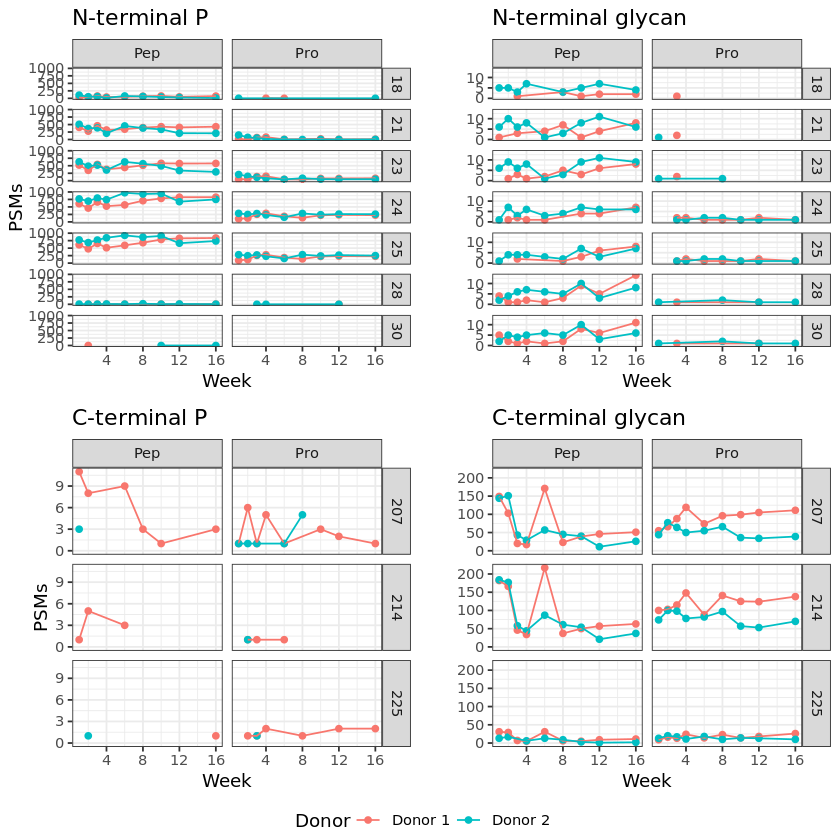

In [19]:
# Extract a legend
legend <- get_legend(# create some space to the left of the legend
  plots[[1]] + theme(
    legend.box.margin = margin(0, 0, 0, 0),
    legend.direction = "horizontal"
  ))


#pdf("plot.pdf", size="a4")
plot_grid(
  rel_heights = c(20, 1),
  ncol = 1,
  plot_grid(
    ncol = 2,
    align = "v",
    axis = "lr",
    plots[[1]] + theme(legend.position = "none"),
    plots[[2]] + theme(legend.position = "none") + ylab(NULL),
    plots[[3]] + theme(legend.position = "none"),
    plots[[4]] + theme(legend.position = "none") + ylab(NULL)
  ),
  legend
)

#dev.off()


## Barplots
Taking it from the "observations" table again, so the functions can be used independently

In [20]:
obs_for_plotting

Accession,Peptide,Peptide_seq,ProPep,Starting_position,Donor,Week,Delta_Mod,|Log_Prob|,Protein_Name,Score,locations,mass,aa,mods,mod_location,glycan,simplified_mod
<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>,<int>,<lgl>,<chr>
P05814,A.RETIES[+79.966]LS[+79.966]S[+79.966]S[+79.966]EESITEY.K,RETIESLSSSEESITEY,Pep,16,Donor 1,1,8.97,3.96,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,213.85,3,0.000,T,,18,FALSE,
P05814,A.RETIES[+79.966]LS[+79.966]S[+79.966]S[+79.966]EESITEY.K,RETIESLSSSEESITEY,Pep,16,Donor 1,1,8.97,3.96,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,213.85,6,79.966,S,P,21,FALSE,P
P05814,A.RETIES[+79.966]LS[+79.966]S[+79.966]S[+79.966]EESITEY.K,RETIESLSSSEESITEY,Pep,16,Donor 1,1,8.97,3.96,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,213.85,8,79.966,S,P,23,FALSE,P
P05814,A.RETIES[+79.966]LS[+79.966]S[+79.966]S[+79.966]EESITEY.K,RETIESLSSSEESITEY,Pep,16,Donor 1,1,8.97,3.96,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,213.85,9,79.966,S,P,24,FALSE,P
P05814,A.RETIES[+79.966]LS[+79.966]S[+79.966]S[+79.966]EESITEY.K,RETIESLSSSEESITEY,Pep,16,Donor 1,1,8.97,3.96,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,213.85,10,79.966,S,P,25,FALSE,P
P05814,A.RETIES[+79.966]LS[+79.966]S[+79.966]S[+79.966]EESITEY.K,RETIESLSSSEESITEY,Pep,16,Donor 1,1,8.97,3.96,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,213.85,13,0.000,S,,28,FALSE,
P05814,A.RETIES[+79.966]LS[+79.966]S[+79.966]S[+79.966]EESITEY.K,RETIESLSSSEESITEY,Pep,16,Donor 1,1,8.97,3.96,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,213.85,15,0.000,T,,30,FALSE,
P05814,A.RETIES[+79.966]LS[+79.966]S[+79.966]S[+79.966]EESITEY.K,RETIESLSSSEESITEY,Pep,16,Donor 1,1,42.05,5.76,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,401.43,3,0.000,T,,18,FALSE,
P05814,A.RETIES[+79.966]LS[+79.966]S[+79.966]S[+79.966]EESITEY.K,RETIESLSSSEESITEY,Pep,16,Donor 1,1,42.05,5.76,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,401.43,6,79.966,S,P,21,FALSE,P


In [21]:
obs_for_plotting %<>%
    mutate(mod_class = ifelse(simplified_mod=="", "Unmodified", ifelse(mass < 100, "Phospho", "Glycan" )))

In [22]:
barplot_counts <- count(obs_for_plotting, Accession, ProPep, Week, Donor, mod_location, aa, mod_class)

In [23]:
head(barplot_counts, 10)

Accession,ProPep,Week,Donor,mod_location,aa,mod_class,n
<chr>,<chr>,<int>,<fct>,<int>,<chr>,<chr>,<int>
P05814,Pep,1,Donor 1,18,T,Phospho,21
P05814,Pep,1,Donor 1,18,T,Unmodified,583
P05814,Pep,1,Donor 1,21,S,Glycan,1
P05814,Pep,1,Donor 1,21,S,Phospho,405
P05814,Pep,1,Donor 1,21,S,Unmodified,215
P05814,Pep,1,Donor 1,23,S,Phospho,521
P05814,Pep,1,Donor 1,23,S,Unmodified,106
P05814,Pep,1,Donor 1,24,S,Phospho,607
P05814,Pep,1,Donor 1,24,S,Unmodified,25


In [24]:
barplot_counts %<>% filter(Accession == "P05814") %>% mutate(position = location_to_factor(paste0(aa, mod_location)))

In [25]:
head(barplot_counts, 10)

Accession,ProPep,Week,Donor,mod_location,aa,mod_class,n,position
<chr>,<chr>,<int>,<fct>,<int>,<chr>,<chr>,<int>,<ord>
P05814,Pep,1,Donor 1,18,T,Phospho,21,T18
P05814,Pep,1,Donor 1,18,T,Unmodified,583,T18
P05814,Pep,1,Donor 1,21,S,Glycan,1,S21
P05814,Pep,1,Donor 1,21,S,Phospho,405,S21
P05814,Pep,1,Donor 1,21,S,Unmodified,215,S21
P05814,Pep,1,Donor 1,23,S,Phospho,521,S23
P05814,Pep,1,Donor 1,23,S,Unmodified,106,S23
P05814,Pep,1,Donor 1,24,S,Phospho,607,S24
P05814,Pep,1,Donor 1,24,S,Unmodified,25,S24


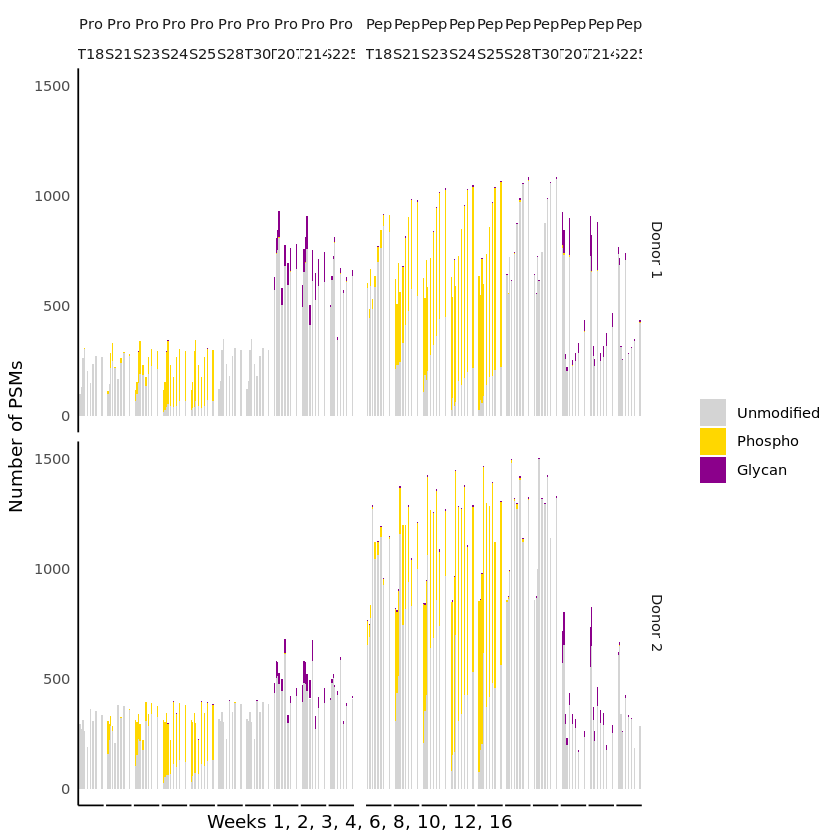

In [26]:
filtered_counts <- barplot_counts %>% filter( mod_location %in% 16:40  | mod_location %in% 190:226)

location_plot <- ggplot(filtered_counts, aes(x=Week, y=n, fill=mod_class)) +
    geom_col(position = "stack") +
    facet_grid(rows = vars(Donor), cols=vars(factor(ProPep, levels=c("Pro","Pep")), position)) +
    scale_fill_manual(values=c("Unmodified"="gray83", "Glycan"="darkmagenta", "Phospho"="gold1")) +
    ylab("Number of PSMs") +
    xlab(paste("Weeks", paste(unique(filtered_counts$Week), collapse = ", "))) +
    guides(fill = guide_legend(reverse = TRUE)) +
    theme_minimal() +
    theme(axis.text.x = element_blank(),
         panel.grid = element_blank(),
         legend.title = element_blank(),
         axis.line = element_line(),
         panel.spacing.x = unit(c(rep(.1,9), .5, rep(.1,9)), "lines"))

location_plot

In [27]:
ggsave(location_plot, file="barplot_byweek.pdf", device="pdf",  paper="a4r", width=27.6, height=21, units="cm")

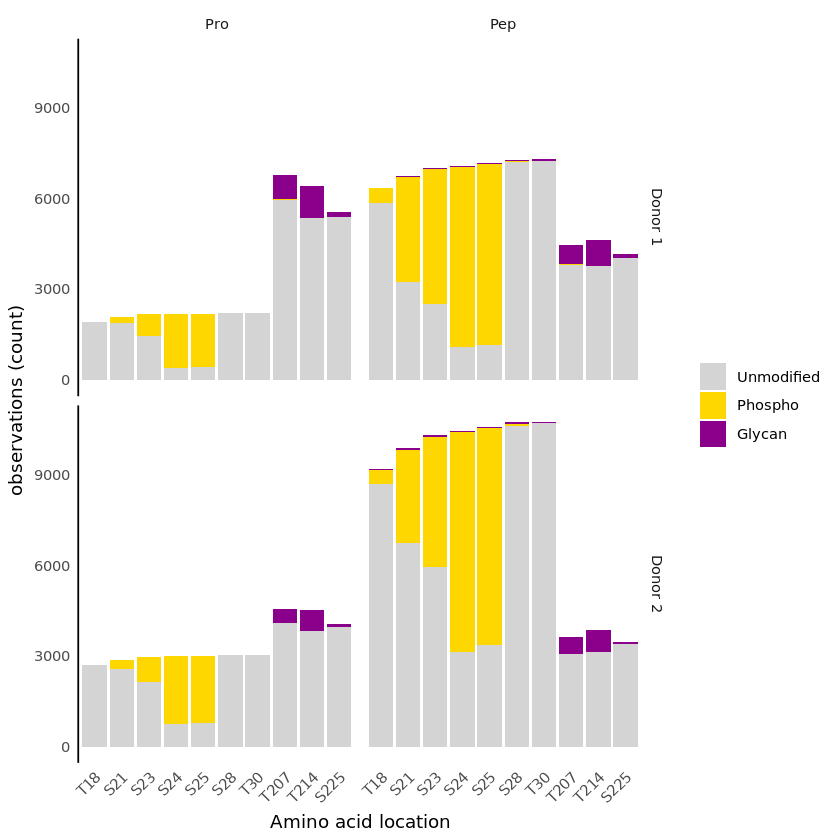

In [28]:
counts_totals  <- count(obs_for_plotting, Accession, ProPep,Donor, mod_location, aa, mod_class)
counts_totals %<>% filter(Accession == "P05814") %>% mutate(position = location_to_factor(paste0(aa, mod_location)))
counts_totals %<>% filter( mod_location %in% 16:40  | mod_location %in% 190:226)

location_totals_plot <- ggplot(counts_totals,
       aes(x=position, y=n, fill=mod_class)) +
    geom_col(position = "stack") +
    facet_grid(rows = vars(Donor), cols=vars(factor(ProPep, levels=c("Pro","Pep")))) +
    scale_fill_manual(values=c("Unmodified"="gray83", "Glycan"="darkmagenta", "Phospho"="gold1")) +
    ylab("observations (count)") +
    xlab("Amino acid location") +
    guides(fill = guide_legend(reverse = TRUE)) +
    theme_minimal() +
    theme(panel.grid = element_blank(),
         legend.title = element_blank(),
         axis.text.x = element_text(angle=45, hjust = 1),
         axis.line.y = element_line())


location_totals_plot

In [29]:
ggsave(location_totals_plot, file="barplot_totals.pdf", device="pdf",  paper="a4r", width=27.6, height=21, units="cm")

## Specific glyco

In [30]:
obs_for_plotting_glyco <- obs_for_plotting %>%
    filter(mod_class=="Glycan" & Accession == "P05814" ) %>%
    mutate(simplified_glyco = as.character(glycans_abbreviated[mods]))

In [31]:
obs_for_plotting_glyco

Accession,Peptide,Peptide_seq,ProPep,Starting_position,Donor,Week,Delta_Mod,|Log_Prob|,Protein_Name,Score,locations,mass,aa,mods,mod_location,glycan,simplified_mod,mod_class,simplified_glyco
<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>,<int>,<lgl>,<chr>,<chr>,<chr>
P05814,A.RETIES[+947.323]LSSSEES[+349.137]IT[+349.137]EYKQK.V,RETIESLSSSEESITEYKQK,Pep,16,Donor 1,1,18.36,2.17,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,178.00,6,947.323,S,HexNAc(1)Hex(1)NeuAc(2),21,TRUE,glycan,Glycan,N1H1S2
P05814,A.RETIES[+947.323]LSSSEES[+349.137]IT[+349.137]EYKQK.V,RETIESLSSSEESITEYKQK,Pep,16,Donor 1,1,18.36,2.17,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,178.00,13,349.137,S,HexNAc(1)dHex(1),28,TRUE,glycan,Glycan,N1F1
P05814,A.RETIES[+947.323]LSSSEES[+349.137]IT[+349.137]EYKQK.V,RETIESLSSSEESITEYKQK,Pep,16,Donor 1,1,18.36,2.17,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,178.00,15,349.137,T,HexNAc(1)dHex(1),30,TRUE,glycan,Glycan,N1F1
P05814,D.QQQGEDEHQDKIYPS[+203.079]FQPQPLIYPFVEPIPYGFLPQNILPLAQPAVVLPVPQPEIMEVPKAKDT[+203.079]VYT[+203.079].K,QQQGEDEHQDKIYPSFQPQPLIYPFVEPIPYGFLPQNILPLAQPAVVLPVPQPEIMEVPKAKDTVYT,Pep,44,Donor 1,1,462.06,3.65,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,462.06,15,203.079,S,HexNAc(1),58,TRUE,glycan,Glycan,N1
P05814,D.QQQGEDEHQDKIYPS[+203.079]FQPQPLIYPFVEPIPYGFLPQNILPLAQPAVVLPVPQPEIMEVPKAKDT[+203.079]VYT[+203.079].K,QQQGEDEHQDKIYPSFQPQPLIYPFVEPIPYGFLPQNILPLAQPAVVLPVPQPEIMEVPKAKDTVYT,Pep,44,Donor 1,1,462.06,3.65,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,462.06,64,203.079,T,HexNAc(1),107,TRUE,glycan,Glycan,N1
P05814,D.QQQGEDEHQDKIYPS[+203.079]FQPQPLIYPFVEPIPYGFLPQNILPLAQPAVVLPVPQPEIMEVPKAKDT[+203.079]VYT[+203.079].K,QQQGEDEHQDKIYPSFQPQPLIYPFVEPIPYGFLPQNILPLAQPAVVLPVPQPEIMEVPKAKDTVYT,Pep,44,Donor 1,1,462.06,3.65,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,462.06,67,203.079,T,HexNAc(1),110,TRUE,glycan,Glycan,N1
P05814,D.QQQGEDEHQDKIYPS[+203.079]FQPQPLIYPFVEPIPYGFLPQNILPLAQPAVVLPVPQPEIMEVPKAKDT[+203.079]VYT[+203.079].K,QQQGEDEHQDKIYPSFQPQPLIYPFVEPIPYGFLPQNILPLAQPAVVLPVPQPEIMEVPKAKDTVYT,Pep,44,Donor 1,1,478.61,3.69,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,478.61,15,203.079,S,HexNAc(1),58,TRUE,glycan,Glycan,N1
P05814,D.QQQGEDEHQDKIYPS[+203.079]FQPQPLIYPFVEPIPYGFLPQNILPLAQPAVVLPVPQPEIMEVPKAKDT[+203.079]VYT[+203.079].K,QQQGEDEHQDKIYPSFQPQPLIYPFVEPIPYGFLPQNILPLAQPAVVLPVPQPEIMEVPKAKDTVYT,Pep,44,Donor 1,1,478.61,3.69,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,478.61,64,203.079,T,HexNAc(1),107,TRUE,glycan,Glycan,N1
P05814,D.QQQGEDEHQDKIYPS[+203.079]FQPQPLIYPFVEPIPYGFLPQNILPLAQPAVVLPVPQPEIMEVPKAKDT[+203.079]VYT[+203.079].K,QQQGEDEHQDKIYPSFQPQPLIYPFVEPIPYGFLPQNILPLAQPAVVLPVPQPEIMEVPKAKDTVYT,Pep,44,Donor 1,1,478.61,3.69,>sp|P05814|CASB_HUMAN Beta-casein OS=Homo sapiens OX=9606 GN=CSN2 PE=1 SV=4,478.61,67,203.079,T,HexNAc(1),110,TRUE,glycan,Glycan,N1


In [32]:
counts_for_glyco <- count(obs_for_plotting_glyco, ProPep, Donor, Accession, simplified_glyco, mod_location, aa)

In [33]:
counts_for_glyco %<>% mutate(location = location_to_factor(paste0(aa, mod_location)))

In [34]:
counts_for_glyco

ProPep,Donor,Accession,simplified_glyco,mod_location,aa,n,location
<chr>,<fct>,<chr>,<chr>,<int>,<chr>,<int>,<ord>
Pep,Donor 1,P05814,N1,18,T,2,T18
Pep,Donor 1,P05814,N1,21,S,4,S21
Pep,Donor 1,P05814,N1,23,S,7,S23
Pep,Donor 1,P05814,N1,24,S,2,S24
Pep,Donor 1,P05814,N1,25,S,3,S25
Pep,Donor 1,P05814,N1,28,S,4,S28
Pep,Donor 1,P05814,N1,30,T,4,T30
Pep,Donor 1,P05814,N1,58,S,47,S58
Pep,Donor 1,P05814,N1,107,T,77,T107


**Palette options:**

|type|names|
|----|-----|
|Diverging | BrBG, PiYG, PRGn, PuOr, RdBu, RdGy, RdYlBu, RdYlGn, Spectral |
|Qualitative | Accent, Dark2, Paired, Pastel1, Pastel2, Set1, Set2, Set3 |
|Sequential | Blues, BuGn, BuPu, GnBu, Greens, Greys, Oranges, OrRd, PuBu, PuBuGn, PuRd, Purples, RdPu, Reds, YlGn, YlGnBu, YlOrBr, YlOrRd |


In [35]:
levels(counts_for_glyco$location)

[1] "T18"  "S21"  "S23"  "S24"  "S25"  "S28"  "T30"  "S58"  "T107" "T110"
[11] "S120" "T122" "T134" "T160" "S170" "T207" "T214" "S225"

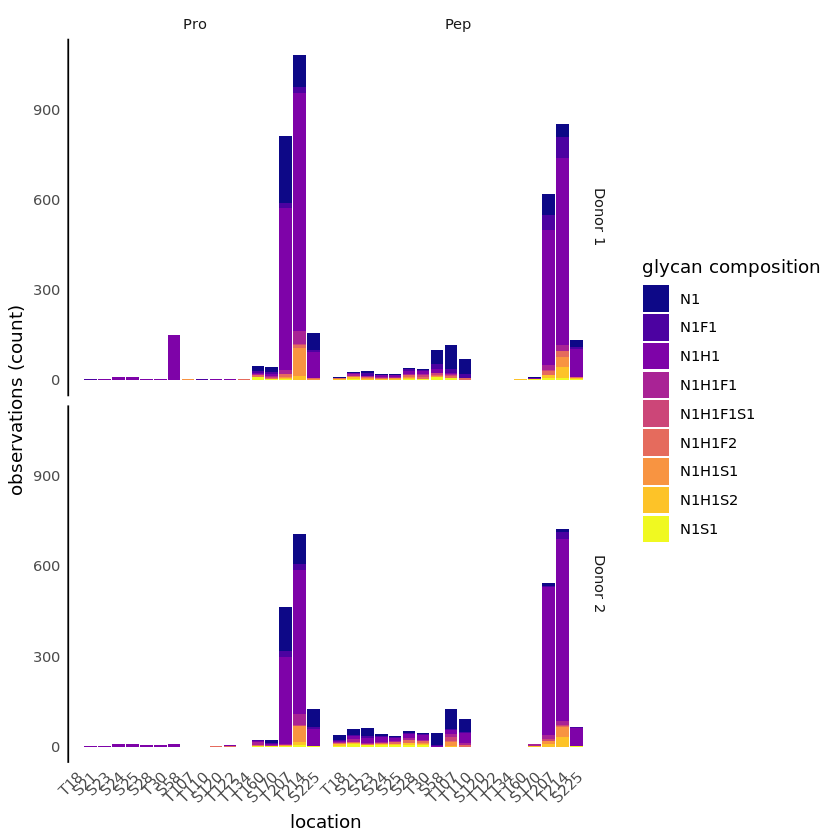

In [36]:
glycolocation_plot <- ggplot(counts_for_glyco, aes(x=location, y=n, fill=simplified_glyco)) +
    geom_col() +
    facet_grid(cols=vars(factor(ProPep, levels=c("Pro","Pep"))), rows=vars(Donor)) +
    ylab("observations (count)") +
    labs(fill = "glycan composition") +
    scale_fill_viridis_d(option="C") +
    theme_minimal() +
    theme(panel.grid = element_blank(),
          axis.text.x = element_text(angle = 45, hjust = 1),
          axis.line.y = element_line())

glycolocation_plot

In [37]:
ggsave(glycolocation_plot, file="glyco_composition.pdf", device="pdf",  paper="a4r", width=27.6, height=21, units="cm")